<a href="https://colab.research.google.com/github/icedumpy/PyTorch-tutorials/blob/main/2_A_GENTLE_INTRODUCTION_TO_TORCH_AUTOGRAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)

# **A Gentle Introduction to *torch.autograd***

* torch.autograd is PyTorch’s **automatic differentiation engine** that powers neural network training. 
* In this section, you will get a conceptual understanding of how autograd helps a neural network train.

# Background

Neural networks (NNs) are a collection of nested functions that are executed on some input data. These functions are defined by parameters (consisting of weights and biases), which in PyTorch are stored in tensors.

Training a NN happens in two steps:
1. **Forward Propagation**: 
    > In forward prop, the NN makes its best guess about the correct output. It runs the input data through each of its functions to make this guess.
2. **Backward Propagation**: 
    > In backprop, the NN adjusts its parameters proportionate to the error in its guess. It does this by traversing backwards from the output, collecting the derivatives of the error with respect to the parameters of the functions (gradients), and optimizing the parameters using gradient descent. For a more detailed walkthrough of backprop, check out this video from [3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).



# Usage in PyTorch

* Let’s take a look at a single training step. For this example, we load a pretrained ***resnet18*** model from *torchvision*. We create a random data tensor to represent a single image with *3* channels, and height & width of *64*, and its corresponding label initialized to some random values.

In [11]:
import torch
import torchvision
model = torchvision.models.resnet18(pretrained=True)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


* Next, we run the input data through the model through each of its layers to make a prediction. This is the forward pass.

In [12]:
prediction = model(data) # forward pass
print(prediction[0, :5])

tensor([-0.1957, -0.5060, -0.5077, -1.5988, -0.7027], grad_fn=<SliceBackward>)


* We use the model’s prediction and the corresponding label to calculate the error (loss). The next step is to backpropagate this error through the network. *Backward propagation* is kicked off when we call *.backward()* on the error tensor. *Autograd* then calculates and stores the gradients for each model parameter in the parameter’s .grad attribute.

In [13]:
loss = (prediction - labels).sum()
loss.backward() # Nani kore!

* Next, we load an optimizer, in this case SGD with a learning rate of 0.01 and momentum of 0.9. We register all the parameters of the model in the optimizer.

In [14]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

* Finally, we call *.step()* to initiate gradient descent. The optimizer adjusts each parameter by its gradient stored in .grad.

In [15]:
optim.step() #gradient descent

* At this point, you have everything you need to train your neural network. The below sections detail the workings of autograd - feel free to skip them.

# Differentiation in Autograd

* Let’s take a look at how *autograd* collects *gradients*. We create two tensors *a* and *b* with *requires_grad=True*. This signals to *autograd* that every operation on them should be tracked.

In [16]:
import torch
a = torch.tensor([2., 3.], requires_grad=True) # requires_grad default is False
b = torch.tensor([6., 4.], requires_grad=True)

* We create another tensor *Q* from *a* and *b*

>> $Q = 3a^3-b^2$

In [17]:
Q = 3*a**3 - b**2

** w.r.t : with respect to
* Let’s assume *a* and *b* to be parameters of an NN, and *Q* to be the *error*. In NN training, we want gradients of the error *w.r.t.* parameters, i.e.

>> $\frac{\partial Q}{\partial a} = 9a^2$

>> $\frac{\partial Q}{\partial b} = -2b$

* When we call .backward() on *Q*, *autograd* calculates these gradients ($\frac{\partial Q}{\partial a}, \frac{\partial Q}{\partial b}$) and stores them in the respective tensors’ .grad attribute.

* We need to ***explicitly*** pass a gradient argument in *Q.backward()* because it is a vector. gradient is a tensor of the same shape as Q, and it represents the gradient of Q w.r.t. itself, i.e.

>> $\frac{\partial Q}{\partial Q} = 1$

* Equivalently, we can also aggregate *Q* into a scalar and call backward implicitly, like Q.sum().backward().

In [18]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

* Gradients are now deposited in *a.grad* and *b.grad*

In [19]:
# Check if collected gradients are correct
print(9*a**2, a.grad)
print(-2*b, b.grad)

tensor([36., 81.], grad_fn=<MulBackward0>) tensor([36., 81.])
tensor([-12.,  -8.], grad_fn=<MulBackward0>) tensor([-12.,  -8.])


# Optional Reading - Vector Calculus using autograd

* Mathematically, if you have a vector valued function $\vec{y}=f(\vec{x})$, then the gradient of $\vec{y}$ with respect to $\vec{x}$ is a Jacobian matrix $J$:

>$\begin{split}J
=
 \left(\begin{array}{cc}
 \frac{\partial \bf{y}}{\partial x_{1}} &
 ... &
 \frac{\partial \bf{y}}{\partial x_{n}}
 \end{array}\right)
=
\left(\begin{array}{ccc}
 \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
 \vdots & \ddots & \vdots\\
 \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
 \end{array}\right)\end{split}$

 * Generally speaking, *torch.autograd* is an engine for computing vector-Jacobian product. That is, **given** any vector $\vec{v}$, compute the product $J^{T}\cdot \vec{v}$.

 * If $\vec{v}$ happens to be the gradient of a scalar function:

> $l
=
g\left(\vec{y}\right)
=
\left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}$

* then by the chain rule, the vector-Jacobian product would be the gradient of $\vec(l)$ with respect to $\vec{x}$:

> $\begin{split}J^{T}\cdot \vec{v}=\left(\begin{array}{ccc}
 \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
 \vdots & \ddots & \vdots\\
 \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
 \end{array}\right)\left(\begin{array}{c}
 \frac{\partial l}{\partial y_{1}}\\
 \vdots\\
 \frac{\partial l}{\partial y_{m}}
 \end{array}\right)=\left(\begin{array}{c}
 \frac{\partial l}{\partial x_{1}}\\
 \vdots\\
 \frac{\partial l}{\partial x_{n}}
 \end{array}\right)\end{split}$
 
* **This characteristic of vector-Jacobian product is what we use in the above example; external_grad represents $\vec{v}$.**

# Computational Graph


* Conceptually, *autograd* keeps a record of data (tensors) & all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG) consisting of Function objects. In this DAG, leaves are the input tensors, roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

* In a forward pass, autograd does two things simultaneously:
> 1. run the requested operation to compute a resulting tensor, and
> 2. maintain the operation’s gradient function in the DAG.

* The backward pass kicks off when *.backward()* is called on the DAG root. *autograd* then:
> 1. computes the gradients from each *.grad_fn*,
> 2. accumulates them in the respective tensor’s *.grad* attribute, and
> 3. using the chain rule, propagates all the way to the leaf tensors.

* Below is a visual representation of the DAG in our example. In the graph, the arrows are in the direction of the forward pass. The nodes represent the backward functions of each operation in the forward pass. The leaf nodes in blue represent our leaf tensors *a* and *b*.

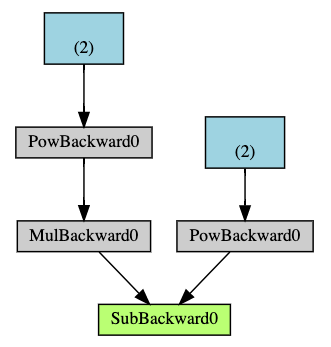

* **DAGs are dynamic in PyTorch An important thing to note is that the graph is recreated from scratch; after each .backward() call, autograd starts populating a new graph. This is exactly what allows you to use control flow statements in your model; you can change the shape, size and operations at every iteration if needed.**



# Exclusion from the DAG


* *torch.autograd* tracks operations on all tensors which have their *requires_grad* flag set to *True*. For tensors that don’t require gradients, setting this attribute to *False* excludes it from the gradient computation DAG.

* **The output tensor of an operation will require gradients even if only a single input tensor has *requires_grad=True*.**

In [20]:
x = torch.rand(5, 5)
y = torch.rand(5, 5)
z = torch.rand((5, 5), requires_grad=True)

a = x + y
print(f"Does `a` require gradients? : {a.requires_grad}")
b = x + z
print(f"Does `b` require gradients?: {b.requires_grad}")

Does `a` require gradients? : False
Does `b` require gradients?: True


* In a NN, parameters that don’t compute gradients are usually called frozen parameters. **It is useful to “freeze” part of your model if you know in advance that you won’t need the gradients of those parameters (this offers some performance benefits by reducing autograd computations).**

* Another common usecase where exclusion from the DAG is important is for [finetuning a pretrained network](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).

* In finetuning, we freeze most of the model and typically only modify the classifier layers to make predictions on new labels. Let’s walk through a small example to demonstrate this. As before, we load a pretrained resnet18 model, and freeze all the parameters.


In [21]:
from torch import nn, optim

model = torchvision.models.resnet18(pretrained=True)

# Freeze all the parameters in the network
for param in model.parameters():
    param.requires_grad = False

* Let’s say we want to finetune the model on a new dataset with 10 labels. In resnet, the classifier is the last linear layer model.fc. We can simply replace it with a new linear layer (unfrozen by default) that acts as our classifier.

In [26]:
model.fc = nn.Linear(512, 10)

* Now all parameters in the model, except the parameters of model.fc, are frozen. The only parameters that compute gradients are the weights and bias of model.fc.



In [27]:
# Optimize only the classifier
optimizer = optim.SGD(model.fc.parameters(), lr=1e-2, momentum=0.9)

* **Notice although we register all the parameters in the optimizer, the only parameters that are computing gradients (and hence updated in gradient descent) are the weights and bias of the classifier.**



* The same exclusionary functionality is available as a context manager in [torch.no_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html)

